In [1]:
%load_ext autoreload
%autoreload 1

import gym
import pymunk


import numpy as np
import matplotlib.pyplot as plt

import torch

In [2]:
import visual
import constant

# Player Stats

## Offensive Stats
- Shooting Profile

## Defensive Stats
- Defensive Contest

## Both
- Top Speed
- Top Acceleration
- Size

In [3]:
class PlayerStat:
    def __init__(self):
        pass
    
    
class BasketballEnv(gym.Env):
    def __init__(self):
        self.space = pymunk.Space()
        self.boundary = 1.1 # simulation boundary
        self.oob = 1. # out of bounds
        
        wall = pymunk.Body(0, 0, pymunk.Body.STATIC)
        bthick = .2
        b = self.boundary+bthick
        walls = [
            pymunk.Segment(wall, (-b, -b), (-b, b), bthick),
            pymunk.Segment(wall, (-b, b), (b, b), bthick),
            pymunk.Segment(wall, (b, b), (b, -b), bthick),
            pymunk.Segment(wall, (b, -b), (-b, -b), bthick),
        ]
        self.space.add(wall, *walls)
        
        self.shot_clock = 0.
        self.shot_clock_max = 24.
        
        self.done = False
        
        self.fps = 4.2
        
        def add_body_to_space(mass, radius):
            xy = tuple(np.random.uniform(-1, 1, size=2).astype(np.float32))
            moment = pymunk.moment_for_circle(mass, 0, radius, (0, 0))
            body = pymunk.Body(mass, moment)
            body.position = xy
            body.start_position = pymunk.Vec2d(*body.position)
            shape = pymunk.Circle(body, radius)
            shape.elasticity = 0.9999999
            self.space.add(body, shape)
            return body
        
        self.stats_offense = [PlayerStat() for _ in range (5)]
        self.stats_defense = [PlayerStat() for _ in range (5)]
        
        self.bodies_offense = [add_body_to_space(1.0, 0.03) for _ in range(5)]
        self.bodies_defense = [add_body_to_space(1.0, 0.03) for _ in range(5)]
        self.bodies_players = [*self.bodies_offense, *self.bodies_defense]
        
        # self.body_ball = add_body_to_space(1.0, 0.02)
        self.body_ball = 0
        self.ball_passing = False
        
        self.action_space = gym.spaces.Discrete(5)
        self.observation_space = gym.spaces.Discrete(2)
            
    def step(self, action):
        dt = 1./self.fps
        
        self.space.step(dt)
        self.shot_clock += dt
        
        self.done = self.shot_clock >= self.shot_clock_max or action.shooting
        
        if type(self.body_ball) is int and type(action.passdata) is int and self.body_ball!=action.passdata:
            self.body_ball = (self.body_ball, action.passdata, 0.)
            self.ball_passing = True
        elif self.ball_passing:
            a, b, t = self.body_ball
            t += 0.1
            self.body_ball = (a, b, t)
            if t>=1.:
                self.body_ball = b
                self.ball_passing = False
        
        reward = 0.
        info = None
        
        if action.shooting:
            reward = 1.
        
        return State(self), reward, self.done, info
        # return obs, reward, done, info
    
    def reset(self):
        return State(self)
    
def get_body_position_numpy(body):
    return np.array([body.position.x, body.position.y])
    
class State:
    def __init__(self, env):
        self.shot_clock = env.shot_clock
        
        self.locs_offense = np.stack([get_body_position_numpy(b) for b in env.bodies_offense]).astype(np.float32)
        self.locs_defense = np.stack([get_body_position_numpy(b) for b in env.bodies_defense]).astype(np.float32)
        
        if type(env.body_ball) is int:
            self.loc_ball = get_body_position_numpy(env.bodies_offense[env.body_ball]).astype(np.float32)
        else:
            a, b, t = env.body_ball
            a = get_body_position_numpy(env.bodies_offense[a]).astype(np.float32)
            b = get_body_position_numpy(env.bodies_offense[b]).astype(np.float32)
            self.loc_ball = (1-t)*a+t*b

class Action:
    def __init__(self):
        self.shooting = False
        self.accs = None
        self.passdata = np.random.randint(low=0, high=5, size=None)
        
env = BasketballEnv()

In [4]:

env = BasketballEnv()

state = env.reset()

for b in env.bodies_players:
    b.velocity = tuple(np.random.randn(2)*0.1)

states = []
for t in range(100):
    action = env.action_space.sample()
    state, reward, done, info = env.step(Action())
    states.append(state)



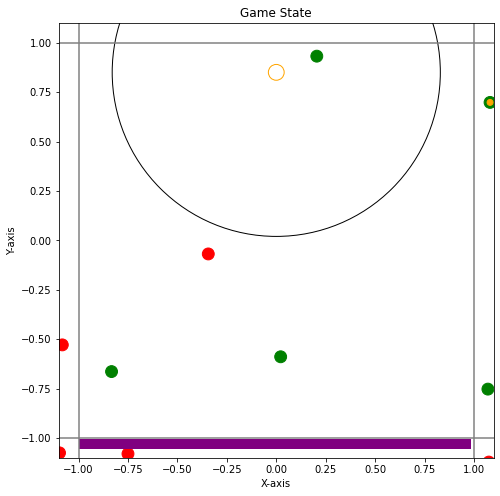

In [5]:
def show_game_state(state, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    # (or if you have an existing figure)
#     fig = plt.gcf()
#     ax = fig.gca()
    ax.set_aspect('equal')
    
    ax.set_xlim(-env.boundary, env.boundary)
    ax.set_ylim(-env.boundary, env.boundary)
    ax.axhline(env.oob, c='gray'); ax.axvline(env.oob, c='gray')
    ax.axhline(-env.oob, c='gray'); ax.axvline(-env.oob, c='gray', label='out of bounds')
    
    for x, y in state.locs_offense:
        circle = plt.Circle((x, y), radius=constant.radius_player, color='g')
        ax.add_artist(circle)
    for x, y in state.locs_defense:
        circle = plt.Circle((x, y), radius=constant.radius_player, color='r')
        ax.add_artist(circle)
    for x, y in [state.loc_ball]:
        circle = plt.Circle((x, y), radius=constant.radius_ball, color='orange')
        ax.add_artist(circle)
    
    ax.add_artist(plt.Circle(constant.pos_hoop.numpy(), radius=constant.radius_hoop, color='orange', fill=False))
    ax.add_artist(plt.Circle(constant.pos_hoop.numpy(), radius=constant.radius_three_point_line, color='k', fill=False))
    
    ax.set_title('Game State')
    ax.set_xlabel('X-axis'); ax.set_ylabel('Y-axis')
    
    ax.barh(y=-1.03, width=2*state.shot_clock/env.shot_clock_max, left=-1., height=0.05, color='purple')
    # plt.grid(
    
    # plt.legend()
    
    return ax

import celluloid
from IPython.display import HTML # to show the animation in Jupyter

def animate_game_states(states, fig=None, ax=None):
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    camera = celluloid.Camera(fig)# the camera gets the fig we'll plot
    for state in states:
        show_game_state(state, ax)
        camera.snap() # the camera takes a snapshot of the plot
    animation = camera.animate() # animation ready
    plt.close()
    vid = HTML(animation.to_html5_video()) # displaying the animation
    return vid

ax = show_game_state(state)
vid = animate_game_states(states)
vid

In [62]:
from torch import nn


class OffenseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.process_player = nn.Sequential(
            nn.Linear(2, 40),
            nn.GELU(),
            nn.Linear(40, 60),
            nn.GELU(),
            nn.Linear(60, 80),
            nn.GELU(),
            nn.Linear(80, 100),
            nn.GELU(),
            nn.Linear(100, 100),
        )
        
    def forward(self, state):
        lo = torch.from_numpy(state.locs_offense)
        ld = torch.from_numpy(state.locs_defense)
        
        processed = self.process_player(lo).mean(dim=-2)
        
        print(lo.shape)
        print(ld.shape)
        print(state)
    
class DefensiveNetwork(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, state):
        pass
    
    
onet = OffenseNetwork()

onet(state)

torch.Size([5, 100])
torch.Size([5, 2])
torch.Size([5, 2])


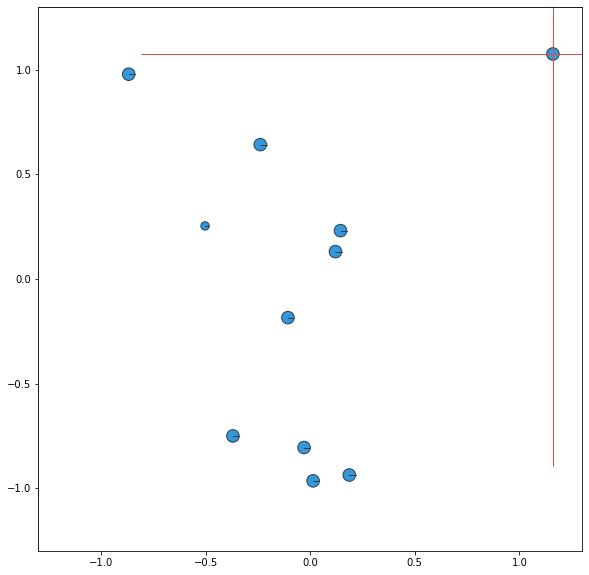

In [277]:
import pymunk.pyglet_util
import pymunk.matplotlib_util

options = pymunk.pyglet_util.DrawOptions()
options = pymunk.SpaceDebugDrawOptions()

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot()
ax.set_aspect('equal')
options = pymunk.matplotlib_util.DrawOptions(ax)
env.space.debug_draw(options)

plt.xlim(-1.3, 1.3); plt.ylim(-1.3, 1.3)
# plt.xlim(-2, 2,); plt.ylim(-2, 2,);

plt.show()

# If we haven't already shown or saved the plot, then we need to
# draw the figure first...
# fig.canvas.draw()

# Now we can save it to a numpy array.
# data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
# data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

In [82]:
import visual
import constant

<AxesSubplot:title={'center':'Game State'}, xlabel='X-axis', ylabel='Y-axis'>

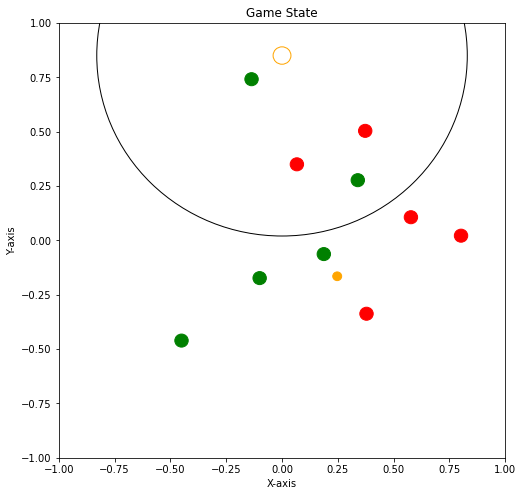

In [218]:
def show_game_state(game_state, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8)) # note we must use plt.subplots, not plt.subplot
    # (or if you have an existing figure)
#     fig = plt.gcf()
#     ax = fig.gca()
    
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    
    for idx_op in constant.idxs_op.numpy():
        x, y = game_state[idx_op]
        circle = plt.Circle((x, y), radius=constant.radius_player, color='g')
        ax.add_artist(circle)
    for idx_dp in constant.idxs_dp.numpy():
        x, y = game_state[idx_dp]
        circle = plt.Circle((x, y), radius=constant.radius_player, color='r')
        ax.add_artist(circle)
    for idx_ball in constant.idxs_ball.numpy():
        x, y = game_state[idx_ball]
        circle = plt.Circle((x, y), radius=constant.radius_ball, color='orange')
        ax.add_artist(circle)
    
    ax.add_artist(plt.Circle(constant.pos_hoop.numpy(), radius=constant.radius_hoop, color='orange', fill=False))
    ax.add_artist(plt.Circle(constant.pos_hoop.numpy(), radius=constant.radius_three_point_line, color='k', fill=False))
    
    ax.set_title('Game State')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    return ax


torch.manual_seed(0)
show_game_state(torch.randn(11, 2)*.4)

<AxesSubplot:title={'center':'Game State'}, xlabel='X-axis', ylabel='Y-axis'>

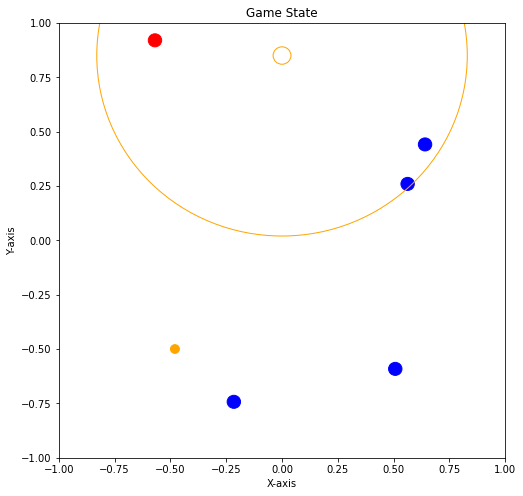

In [209]:
visual.show_game_state(torch.randn(11, 2))

# GIFs in JupyterLab

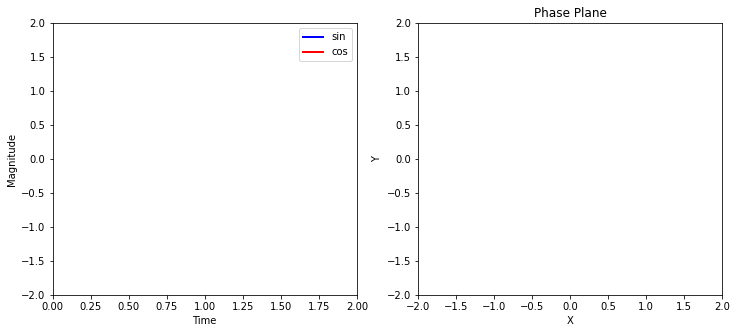

In [282]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# create a figure and axes
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)   
ax2 = plt.subplot(1,2,2)

# set up the subplots as needed
ax1.set_xlim(( 0, 2))            
ax1.set_ylim((-2, 2))
ax1.set_xlabel('Time')
ax1.set_ylabel('Magnitude')

ax2.set_xlim((-2,2))
ax2.set_ylim((-2,2))
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Phase Plane')

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
txt_title = ax1.set_title('')
line1, = ax1.plot([], [], 'b', lw=2)     # ax.plot returns a list of 2D line objects
line2, = ax1.plot([], [], 'r', lw=2)
pt1, = ax2.plot([], [], 'g.', ms=20)
line3, = ax2.plot([], [], 'y', lw=2)

ax1.legend(['sin','cos']);


In [283]:

# animation function. This is called sequentially
def drawframe(n):
    x = np.linspace(0, 2, 1000)
    y1 = np.sin(2 * np.pi * (x - 0.01 * n))
    y2 = np.cos(2 * np.pi * (x - 0.01 * n))
    line1.set_data(x, y1)
    line2.set_data(x, y2)
    line3.set_data(y1[0:50],y2[0:50])
    pt1.set_data(y1[0],y2[0])
    txt_title.set_text('Frame = {0:4d}'.format(n))
    return (line1,line2)

In [284]:
from matplotlib import animation

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=100, interval=20, blit=True)

In [286]:
from IPython.display import HTML
# HTML(anim.to_html5_video())

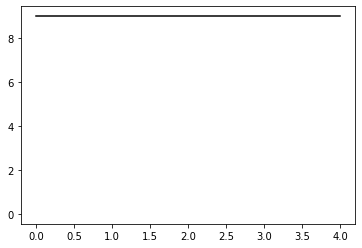